In [22]:
from typing import Tuple, List, Optional
from dataclasses import dataclass
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Define some data structures for better code syntax.

@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [24]:
# Define motion model, motion model Jacobian, observation model, and its Jacobian

def motion_model(state, g, dt):
    return np.array([state[0] + state[1]*dt, state[1] - g*np.sin(state[0])*dt])

def motion_model_Jacobian(state, g, dt):
    return np.array([[1., dt], [-g * np.cos(state[0]) * dt, 1.]])

def observation_model(state):
    return np.array([np.sin(state[0])])

def observation_model_Jacobian(state, dt):
    return np.array([[np.cos(state[0]), 0.]])

In [25]:
# Define prediction step and update step for the Extended Kalman Filter

def EKF_prediction_step(X: Gaussian, xi: Gaussian, g: np.float32, dt: np.float32) -> Gaussian:
    """Linear Prediction Step: Propagate uncertainty for one time step.

    X_{k+1} = g(X_{k}) + xi, xi sim mathcal{N}{noise_mean, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    X: Gaussian := state variable
    xi: Gaussian := noise variable
    dt: np.float32 := time step

    Intermediates:
    pred_mean := bar{mu} := predicted mean of the state
    pred_cov := bar{Sigma}j := predicted covariance of the state

    Returns
    -------
    A Gaussian random variable for the next time step
    J := predicted covariance of the state
    pred_cov := bar{Sigma} := predicted covariance of the state

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    pred_mean = motion_model(X.mean, g, dt) + xi.mean
    J = motion_model_Jacobian(X.mean, g, dt)
    pred_cov = J @ X.cov @ J.T + xi.cov
    return Gaussian(pred_mean, pred_cov)

In [26]:
def EKF_update_step(data: np.ndarray, X: Gaussian, eta: Gaussian, g: np.float32, dt: np.float32) -> Gaussian:
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    X: Gaussian := state variable
    eta: Gaussian := noise variable

    Intermediates:
    H := measurement/observation model Jacobian
    X := State distrubution
    eta := noise distribution

    Returns
    -------
    Gaussian Posterior
    """
    H = observation_model_Jacobian(X.mean, dt)
    U = np.dot(X.cov, H.T)
    S = np.dot(H, U) + eta.cov
    mu = np.dot(H, X.mean) + eta.mean

    # Kalman Gain
    K = np.linalg.solve(S, H@X.cov).T
    update_mean = X.mean + K@np.atleast_1d(data - mu)
    update_cov = X.cov - K@S@K.T
    

    #update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    #update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)

In [27]:
# Define the main loop for the Extended Kalman Filter

def extended_kalman_filter(data: Observations,
                  X: Gaussian,
                  xi: Gaussian,
                  eta: Gaussian, 
                  g: np.float32,
                  dt: np.float32) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    X: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    EKFTracker
    """

    num_steps = data.times.shape[0]
    d = X.mean.shape[0]


    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)

    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = X
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = EKF_prediction_step(Xnext, xi, g, dt)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = EKF_update_step(y, Xpred, eta, g, dt)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, : ,:] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

In [28]:
# Write a function to generate truth as well as simulated observed data.

def generate_data(times: np.ndarray,
                  N: int,
                  g: np.float32,
                  dt: np.float32,
                  obs_freq: int,
                  x0: np.ndarray,
                  O: np.ndarray,
                  obs_names: List[str],
                  mm: np.ndarray,
                  Q: np.ndarray,
                  om: np.float32,
                  R: np.float32) -> Tuple[Observations, Observations]:

    """Generate the truth and data for the second-order system

    times:= time instances for simulation
    N:= number of time steps
    dt:= time step
    obs_freq:+ frequency to capture model observations
    x0:= initial state
    obs_names:= names of the observations
    O:= observation matrix, describes which states are to be observed
    mm: motion model noise mean
    Q: motion model noise covariance matrix
    om: measurement model noise mean
    R: measurement model noise covariance matrix

    """
    xout = np.zeros((N, 2)) # output states
    xout[0, :] = x0         # populate output with initial state

    obs_ind = np.arange(obs_freq, N, obs_freq) # indices where observations have to be performed
    num_obs =  obs_ind.shape[0] # number of observations
    on_obs = 0 # number of observations recorded
    yout = np.zeros((num_obs, O.shape[0]))

    for ii in range(1, N):
        xout[ii, :] = motion_model(xout[ii-1, :], g, dt) # populate dynamics update
        if on_obs < num_obs and ii == obs_ind[on_obs]:
            # populate observsation update
            #yout[on_obs, :] = np.dot(O, xout[ii, :]) + np.random.normal(om, np.sqrt(R))
            yout[on_obs, :] = observation_model(xout[ii, :]) + np.random.normal(om, np.sqrt(R))
            on_obs += 1

    trueData = Observations(times, np.arange(N), xout, ['state0', 'state1'])
    obsData = Observations(times, obs_ind, yout, obs_names)
    return trueData, obsData

In [29]:
# unchanging simulation parameters
dt, Nsims_ekf, g, qc_ekf = 1e-2, 500, 9.8, 0.1
Tf_ekf = Nsims_ekf * dt
time_ekf, x0_ekf, obs_names_ekf = np.linspace(0, Tf_ekf, Nsims_ekf), np.array([1.50, 0]), ['observed s1: angle', 'observed s2: angular rate']
X_ekf = Gaussian(x0_ekf, np.eye(2)) # prior
O_ekf = np.array([[1, 0]]) # observation matrix
mm_ekf = np.zeros(2) # process model noise mean
Q_ekf = np.array([[qc_ekf*dt**3/3, qc_ekf*dt**2/2], [qc_ekf*dt**2/2, qc_ekf*dt]]) # process model noie covariance
om_ekf = 0.0 # measurement model noise mean

# changing simulation parameters
#deltas_ekf = np.array([5, 10, 20, 40])
#Rs_ekf = np.array([1, 0.1, 0.01, 0.001])

# for overlay analysis
deltas_ekf = np.array([5])
Rs_ekf = np.array([1, 0.1, 0.01])

colors = ['blue', 'green']

In [30]:
def plot_grid(rows, cols, figsize, deltas, Rs, time, Nsims, g, dt, x0, O, obs_names, mm, Q, om, X):
  fig, axs = plt.subplots(rows, cols, figsize=figsize)
  kf_results = []
  for i in range(len(deltas)):
    for j in range(len(Rs)):
      truth, noisy_obs = generate_data(time, Nsims, g, dt, deltas[i], x0, O, obs_names, mm, Q, om, Rs[j])
      process_noise = Gaussian(mm, np.sqrt(Q))
      meas_noise = Gaussian(om, np.sqrt(Rs[j]))
      kf_res = extended_kalman_filter(noisy_obs, X, process_noise, meas_noise, g, dt)
      kf_results.append(kf_res)

      # compute RMSE
      RMSE = np.sqrt(np.mean((kf_res.means - truth.obs)**2))

      axs[i, j].plot(truth.times, truth.obs[:, 0], color=colors[0], label='state0: angle')
      axs[i, j].plot(truth.times, truth.obs[:, 1], color=colors[1], label='state1: angular rate')

      axs[i, j].plot(noisy_obs.times, kf_res.means[:, 0], '--', color=colors[0], label='est-state0: angle')
      axs[i, j].plot(noisy_obs.times, kf_res.means[:, 1], '--', color=colors[1], label='est-state1: angular rate')
      axs[i, j].fill_between(noisy_obs.times,
                         kf_res.means[:, 0] - 2 * kf_res.stds[:, 0],
                         kf_res.means[:, 0] + 2 * kf_res.stds[:, 0],
                         color=colors[0], alpha=0.3)
      axs[i, j].fill_between(noisy_obs.times,
                         kf_res.means[:, 1] - 2 * kf_res.stds[:, 1],
                         kf_res.means[:, 1] + 2 * kf_res.stds[:, 1],
                         color=colors[1], alpha=0.3)

      axs[i, j].set_xlabel('Time', fontsize=10)
      axs[i, j].set_ylabel('State Estimate',fontsize=10)
      axs[i, j].set_title(f'Delta: {deltas[i]}, R: {Rs[j]} and RMSE error: {np.round(RMSE, 3)}', fontsize=10)


      for ii in range(noisy_obs.obs.shape[1]):
        axs[i, j].scatter(noisy_obs.times[noisy_obs.obs_ind], noisy_obs.obs,
                           color=colors[ii], alpha=0.4, label=noisy_obs.names[0])

      axs[i, j].legend()

  plt.savefig('ekf.png', dpi=300, bbox_inches='tight')
  plt.show()

  return kf_results

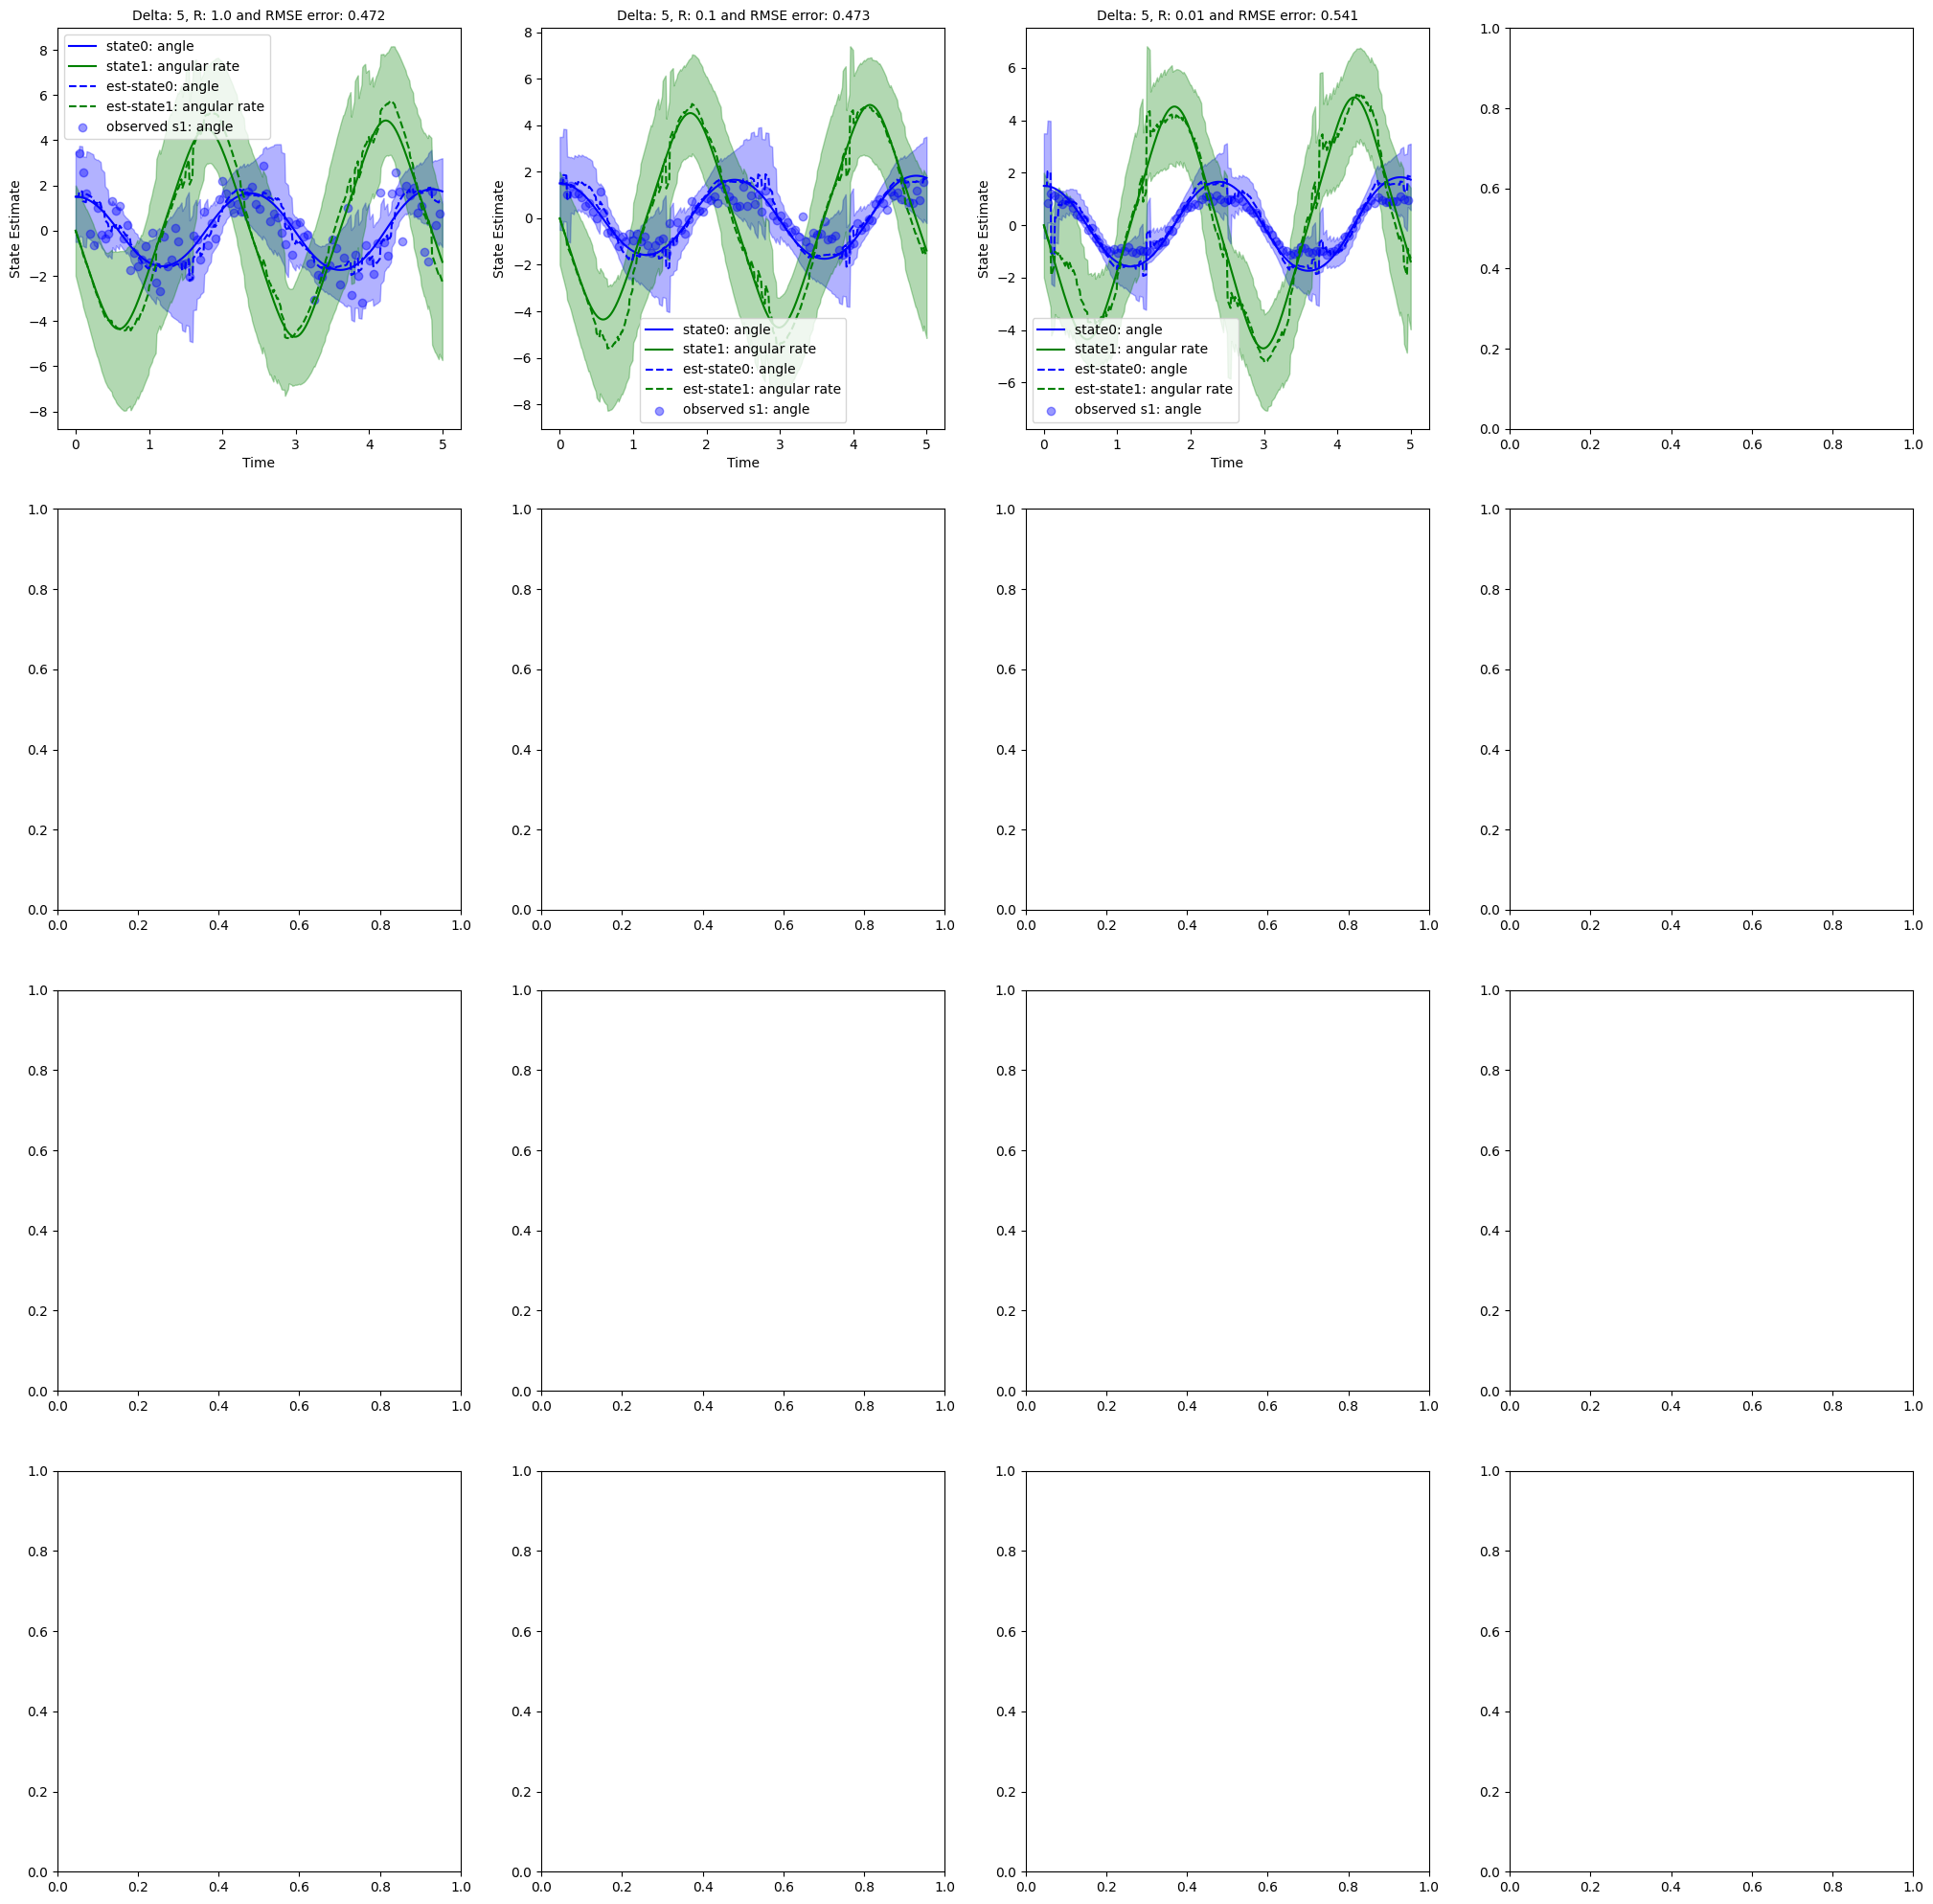

In [32]:
kf_results = plot_grid(4, 4, (25, 25), deltas_ekf, Rs_ekf, time_ekf, Nsims_ekf, g, dt, x0_ekf, O_ekf, obs_names_ekf, mm_ekf, Q_ekf, om_ekf, X_ekf)

In [ ]:
# save the varibale kf_results with pickle
import pickle
with open('kf_results_ekf.pkl', 'wb') as f:
  pickle.dump(kf_results, f)